In [1]:
import sys
import os
import time
import numpy as np
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import meshcat.geometry as g
import meshcat.transformations as tf
plt.style.use('seaborn-v0_8')

# Add the bsqp interface to path
sys.path.append('./build/python')

from bsqp.interface import BSQP
from force_estimator_cem import CEMForceEstimator

np.set_printoptions(linewidth=99999999)
np.random.seed(42)

urdf_path = "iiwa_description/iiwa14.urdf"
model_dir = "iiwa_description/"

class MPC_GATO:
    def __init__(self, model, N, dt, batch_size, pendulum_mass=15.0, pendulum_length=0.4, pendulum_damping=0.1):
        # Store original model for solver (without pendulum)
        self.solver_model = model
        self.solver_data = self.solver_model.createData()
        self.pendulum_mass = pendulum_mass
        self.pendulum_length = pendulum_length
        self.pendulum_damping = pendulum_damping
        
        # Create augmented model for simulation with pendulum
        self.model = self.add_pendulum_to_model(model.copy())
        self.model.gravity.linear = np.array([0, 0, -9.81])
        self.data = self.model.createData()
        
        self.solver = BSQP(model_path=urdf_path, batch_size=batch_size, N=N, dt=dt,
            max_sqp_iters=1,
            kkt_tol=0.0,
            max_pcg_iters=200,
            pcg_tol=1e-3,
            solve_ratio=1.0,
            mu=1.0,
            q_cost=5.0,
            qd_cost=1e-4,
            u_cost=4e-7,
            N_cost=50.0,
            q_lim_cost=0.0,
            vel_lim_cost=0.1,
            ctrl_lim_cost=0.0,
            rho=0.01
        )
        self.q_traj, self.q_traj_full = [], []
        
        # Dimensions - model has extra DOFs from pendulum
        self.nq_robot, self.nv_robot = self.solver_model.nq, self.solver_model.nv
        self.nq, self.nv = self.model.nq, self.model.nv  # Robot + pendulum
        self.nx = self.nq_robot + self.nv_robot  # Solver state dimension (robot only)
        self.nu = self.solver_model.nv  # Control dimension (robot only)
        self.N, self.dt, self.batch_size = N, dt, batch_size
        self.current_force_batch = None

        self.force_estimator = CEMForceEstimator(batch_size=batch_size) if batch_size > 1 else None
        
        self.q_limits = np.array([
            [-2.96706,  2.96706],
            [-2.09440,  2.09440],
            [-2.96706,  2.96706],
            [-2.09440,  2.09440],
            [-2.96706,  2.96706],
            [-2.09440,  2.09440],
            [-3.05433,  3.05433],
        ])
        self.qd_limits = np.array([
            [-1.48353,  1.48353],
            [-1.48353,  1.48353],
            [-1.74533,  1.74533],
            [-1.30900,  1.30900],
            [-2.26893,  2.26893],
            [-2.35619,  2.35619],
            [-2.35619,  2.35619],
        ])
        self.u_limits = np.array([
            [-320.0, 320.0],
            [-320.0, 320.0],
            [-176.0, 176.0],
            [-176.0, 176.0],
            [-110.0, 110.0],
            [ -40.0,  40.0],
            [ -40.0,  40.0],
        ])
    
    def add_pendulum_to_model(self, model):
        """Add a 3D pendulum to the end-effector."""
        pendulum_joint_id = model.addJoint(model.njoints - 1, pin.JointModelSpherical(),pin.SE3.Identity(),"pendulum_joint") 

        # Create inertia for pendulum bob
        com = np.array([0.0, 0.0, -self.pendulum_length])  # Center of mass along -Z
        inertia_matrix = np.diag([0.001, 0.001, 0.001])  # Small inertia at COM
        pendulum_inertia = pin.Inertia(self.pendulum_mass, com, inertia_matrix)
        model.appendBodyToJoint(pendulum_joint_id, pendulum_inertia, pin.SE3.Identity())

        return model
    
    def transform_force_to_gato_frame(self, q, f_world):
        """
        Transform a force from world frame at end-effector to local frame at joint 5.
        Uses only robot joints (first nq_robot elements of q).
        """
        # Create data for solver model to do kinematics
        pin.forwardKinematics(self.solver_model, self.solver_data, q[:self.nq_robot])
        pin.updateFramePlacements(self.solver_model, self.solver_data)

        transform_world_to_ee = self.solver_data.oMi[self.solver_model.njoints - 1]
        
        force_ee_local = transform_world_to_ee.actInv(pin.Force(f_world[:3], f_world[3:]))

        result = np.zeros(6)
        result[:3] = force_ee_local.linear
        result[3:] = force_ee_local.angular

        return result
    
    def update_force_batch(self, q):
        if self.batch_size > 1:
            self.current_force_batch = self.force_estimator.generate_batch()
            self.solver.set_f_ext_B(self.current_force_batch)

    def check_limits(self, t, q_robot, dq_robot, u_robot=None):
        """Check joint position, velocity, and control limits and print/log any violations.
        Returns a dict of violations (empty if none).
        """
        viol = {}
        # Positions
        qmin, qmax = self.q_limits[:, 0], self.q_limits[:, 1]
        q_low = np.where(q_robot < qmin)[0]
        q_high = np.where(q_robot > qmax)[0]
        if q_low.size or q_high.size:
            viol['q'] = {'low': q_low.tolist(), 'high': q_high.tolist(), 'vals': q_robot[(list(q_low)+list(q_high))].tolist()}
            idxs = list(q_low) + list(q_high)
            msgs = [f"j{int(i)}={q_robot[int(i)]:.3f} in [{qmin[int(i)]:.3f},{qmax[int(i)]:.3f}]" for i in idxs]
            print(f"[LIMIT][q ] t={t:6.3f}s -> {'; '.join(msgs)}")
        # Velocities
        vmin, vmax = self.qd_limits[:, 0], self.qd_limits[:, 1]
        v_low = np.where(dq_robot < vmin)[0]
        v_high = np.where(dq_robot > vmax)[0]
        if v_low.size or v_high.size:
            viol['qd'] = {'low': v_low.tolist(), 'high': v_high.tolist(), 'vals': dq_robot[(list(v_low)+list(v_high))].tolist()}
            idxs = list(v_low) + list(v_high)
            msgs = [f"j{int(i)}={dq_robot[int(i)]:.3f} in [{vmin[int(i)]:.3f},{vmax[int(i)]:.3f}]" for i in idxs]
            print(f"[LIMIT][qd] t={t:6.3f}s -> {'; '.join(msgs)}")
        # Controls
        if u_robot is not None:
            umin, umax = self.u_limits[:, 0], self.u_limits[:, 1]
            u_low = np.where(u_robot < umin)[0]
            u_high = np.where(u_robot > umax)[0]
            if u_low.size or u_high.size:
                viol['u'] = {'low': u_low.tolist(), 'high': u_high.tolist(), 'vals': u_robot[(list(u_low)+list(u_high))].tolist()}
                idxs = list(u_low) + list(u_high)
                msgs = [f"j{int(i)}={u_robot[int(i)]:.2f} in [{umin[int(i)]:.2f},{umax[int(i)]:.2f}]" for i in idxs]
                print(f"[LIMIT][u ] t={t:6.3f}s -> {'; '.join(msgs)}")
        return viol
    
    def evaluate_best_trajectory(self, x_last, u_last, x_curr, dt):
        """Evaluate which trajectory best matches reality"""
        if self.batch_size == 1:
            return 0
        else:
            x_next_batch = self.solver.sim_forward(x_last, u_last, dt)
            errors = np.linalg.norm(x_next_batch - x_curr[None, :], axis=1)
            best_id = np.argmin(errors)
            self.force_estimator.update(best_id, errors, batch_used=self.current_force_batch)
            return best_id
                
    def run_mpc(self, x_start, goals, sim_dt, time_per_goal):        
            
        stats = {
            'solve_times': [],
            'goal_distances': [],
            'ee_goal': [],
            'ee_actual': [],  # Actual end-effector positions
            'ee_velocity': [],  # End-effector velocities
            'controls': [],  # Control inputs (torques)
            'joint_positions': [],  # All joint positions
            'joint_velocities': [],  # All joint velocities
            'timestamps': [],  # Time stamps for each step
            'sqp_iters': [],  # SQP iterations
            'pcg_iters': [],  # PCG iterations
            'force_estimates': [],  # Force estimates (if batch)
            'force_estimates_gato': [],  # Force estimates in GATO frame
            'force_radius': [],  # Force estimator search radius
            'force_confidence': [],  # Force estimator confidence
            'best_trajectory_id': [],  # Which trajectory was selected
            'limit_violations': []  # Any q/qd/u limit violations with timestamps
        }
        stats['goal_outcomes_by_idx'] = ['not_reached'] * len(goals)
        
        total_sim_time, accumulated_time, steps = 0.0, 0.0, 0   
        
        x_start_aug = np.zeros(self.nq + self.nv)
        x_start_aug[:self.nx] = x_start  # Robot initial state
        x_start_aug[self.nq_robot:self.nq_robot+3] = np.array([0.3, 0.0, 0.0])  # Pendulum starts with small initial angle
        
        q, dq = x_start_aug[:self.nq], x_start_aug[self.nq:]
        
        x_curr = x_start
        x_curr_batch = np.tile(x_curr, (self.batch_size, 1))
        
        # Initialize first goal
        current_goal_idx = 0
        current_goal = goals[current_goal_idx]
        ee_g = np.tile(np.concatenate([current_goal, np.zeros(3)]), self.N)
        ee_g_batch = np.tile(ee_g, (self.batch_size, 1))
        
        XU = np.zeros(self.N*(self.nx+self.nu)-self.nu)
        XU_batch = np.tile(XU, (self.batch_size, 1))
        
        # Warm up run with initial force batch
        self.update_force_batch(q)
        solve_start = time.time()
        XU_batch, gpu_solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
        solve_time = time.time() - solve_start
        XU_best = XU_batch[0, :]
        
        print(f"\n========== Running MPC for {time_per_goal * len(goals)} seconds with N={self.N} and batch size={self.batch_size} ==========")
        
        goal_start_time = total_sim_time
        while total_sim_time < time_per_goal * len(goals):
            steps += 1
            
            timestep = solve_time
            
            x_last = x_curr
            u_last = XU_best[self.nx:self.nx+self.nu]
            
            # ----- Step Simulation -----
            
            nsteps = int(timestep/sim_dt)
            for i in range(nsteps):
                offset = int(i/(self.dt/sim_dt)) 
                u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)] # get correct control input
                
                u_aug = np.zeros(self.nv)
                u_aug[:self.nu] = u
                u_aug[self.nu:] = -self.pendulum_damping * dq[self.nv_robot:] # viscous damping on pendulum
                
                q, dq = self.rk4(q, dq, u_aug, sim_dt)
                # Check state limits after integration
                viol = self.check_limits(total_sim_time, q[:self.nq_robot], dq[:self.nv_robot], None)
                total_sim_time += sim_dt
                timestep -= sim_dt
                self.q_traj.append(q[:self.nq_robot])  # Store only robot joints
                self.q_traj_full.append(q.copy())  # Store full state
                
            accumulated_time += timestep % sim_dt 
                
            if accumulated_time - sim_dt > 0.0: # if the accumulated time is greater than sim_dt, integrate
                accumulated_time = 0.0
                
                offset = int(nsteps/(self.dt/sim_dt))
                u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                viol = self.check_limits(total_sim_time, q[:self.nq_robot], dq[:self.nv_robot], u)
                
                u_aug = np.zeros(self.nv)
                u_aug[:self.nu] = u
                u_aug[self.nu:] = -self.pendulum_damping * dq[self.nv_robot:]
                
                q, dq = self.rk4(q, dq, u_aug, sim_dt)
                viol = self.check_limits(total_sim_time, q[:self.nq_robot], dq[:self.nv_robot], None)
                if viol:
                    stats['limit_violations'].append({'t': total_sim_time, 'viol': viol})
                total_sim_time += sim_dt
                self.q_traj.append(q[:self.nq_robot]) 
                self.q_traj_full.append(q.copy()) 
            
            # ----- Optimize trajectory toward current goal -----
            
            current_dist, current_vel = np.linalg.norm(self.eepos(q[:self.nq_robot]) - current_goal), np.linalg.norm(dq[:self.nv_robot], ord=1)
            reached = (current_dist < 5e-2) and (current_vel < 1.0)
            timeout = (total_sim_time - goal_start_time) >= time_per_goal
            if reached or timeout:
                if reached:
                    stats['goal_outcomes_by_idx'][current_goal_idx] = 'reached'
                    print(f"\nREACHED Goal {current_goal_idx} at {total_sim_time:4.3f}s\n")
                else:
                    stats['goal_outcomes_by_idx'][current_goal_idx] = 'timeout'
                    print(f"\nTIMEOUT Goal {current_goal_idx} at {total_sim_time:4.3f}s\n")
                current_goal_idx += 1
                if current_goal_idx >= len(goals):
                    print("All goals processed")
                    break
                current_goal = goals[current_goal_idx]
                ee_g = np.tile(np.concatenate([current_goal, np.zeros(3)]), self.N)
                goal_start_time = total_sim_time
                self.solver.solver.reset_rho()
            
            x_curr = np.concatenate([q[:self.nq_robot], dq[:self.nv_robot]])
            x_curr_batch = np.tile(x_curr, (self.batch_size, 1))
            ee_g_batch[:, :] = ee_g
            XU_batch[:, :self.nx] = x_curr
            
            self.update_force_batch(q)
        #     self.solver.solver.reset_rho()
        #     self.solver.solver.reset_dual()
            solve_start = time.time()
            XU_batch_new, gpu_solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
            solve_time = time.time() - solve_start
            best_id = self.evaluate_best_trajectory(x_last, u_last, x_curr, sim_dt)

            XU_best = XU_batch_new[best_id, :]
            XU_batch[:, :] = XU_best
            # -----
            
            ee_pos = self.eepos(q[:self.nq_robot])
            pin.forwardKinematics(self.solver_model, self.solver_model.createData(), q[:self.nq_robot], dq[:self.nv_robot])
            ee_vel = pin.getFrameVelocity(self.solver_model, self.solver_model.createData(), 6, pin.LOCAL_WORLD_ALIGNED).linear
            
            stats['timestamps'].append(total_sim_time)
            stats['solve_times'].append(float(round(gpu_solve_time/1e3, 5)))
            goaldist = np.sqrt(np.sum((ee_pos[:3] - current_goal)**2))
            stats['goal_distances'].append(float(round(goaldist, 5)))
            stats['ee_goal'].append(current_goal.copy())
            stats['ee_actual'].append(ee_pos.copy())
            stats['ee_velocity'].append(ee_vel.copy())
            stats['controls'].append(u_last.copy())
            stats['joint_positions'].append(q[:self.nq_robot].copy())
            stats['joint_velocities'].append(dq[:self.nv_robot].copy())
            stats['best_trajectory_id'].append(best_id)
            
            solver_stats = self.solver.get_stats()
            stats['sqp_iters'].append(solver_stats['sqp_iters'])
            stats['pcg_iters'].append(solver_stats['pcg_iters'][0] if len(solver_stats['pcg_iters']) > 0 else 0)

            # Calculate actual pendulum force reaction
            pendulum_com_acc = pin.getFrameClassicalAcceleration(self.model, self.data, self.model.njoints-1, pin.LOCAL_WORLD_ALIGNED).linear
            pendulum_force = -self.pendulum_mass * (pendulum_com_acc - self.model.gravity.linear)

            # Transform world-frame pendulum force at EE to the solver's GATO EE frame
            pendulum_force6_world = np.concatenate([pendulum_force, np.zeros(3)])
            pendulum_force6_gato = self.transform_force_to_gato_frame(q[:self.nq_robot], pendulum_force6_world)
        
            if steps % 512 == 0:
                if self.force_estimator:
                    est_stats = self.force_estimator.get_stats()
                    mu = est_stats['mu']
                    pf = pendulum_force6_gato
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | qd=\033[93m{current_vel:4.3f}\033[0m | t_sqp=\033[92m{gpu_solve_time/1e3:4.3f}\033[0m ms | pcg_iters={stats['pcg_iters'][-1]} | id={best_id} | f_gato=[{mu[0]:5.1f}, {mu[1]:5.1f}, {mu[2]:5.1f}] | f_p_gato=[{pf[0]:5.1f}, {pf[1]:5.1f}, {pf[2]:5.1f}] | t={total_sim_time:4.3f}s")
                else:
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | qd=\033[93m{current_vel:4.3f}\033[0m | t_sqp=\033[92m{gpu_solve_time/1e3:4.3f}\033[0m ms | pcg_iters={stats['pcg_iters'][-1]} | t={total_sim_time:4.3f}s")

        print(f"avg err: {np.mean(stats['goal_distances']):4.3f}")
        print(f"avg t_sqp: {np.mean(stats['solve_times']):4.3f}ms")
        print(f"========== MPC finished ==========")
        
        # Convert lists to numpy arrays for easier processing (shape-safe)
        def _to_array_safe(seq):
            if not seq:
                return np.array([])
            try:
                first = np.asarray(seq[0])
                same = True
                fshape = first.shape
                for s in seq[1:]:
                    if np.asarray(s).shape != fshape:
                        same = False
                        break
                if same:
                    if first.ndim == 0:
                        return np.asarray(seq)
                    else:
                        return np.stack([np.asarray(x) for x in seq], axis=0)
                else:
                    return np.array(seq, dtype=object)
            except Exception:
                return np.array(seq, dtype=object)

        for key in list(stats.keys()):
            if stats[key]:
                stats[key] = _to_array_safe(stats[key])

        return self.q_traj, stats
    
    def rk4(self, q, dq, u, dt):
        k1q = dq
        k1v = pin.aba(self.model, self.data, q, dq, u)
        q2 = pin.integrate(self.model, q, k1q * dt / 2)
        k2q = dq + k1v * dt/2
        k2v = pin.aba(self.model, self.data, q2, k2q, u)
        q3 = pin.integrate(self.model, q, k2q * dt / 2)
        k3q = dq + k2v * dt/2
        k3v = pin.aba(self.model, self.data, q3, k3q, u)
        q4 = pin.integrate(self.model, q, k3q * dt)
        k4q = dq + k3v * dt
        k4v = pin.aba(self.model, self.data, q4, k4q, u)
        dq_next = dq + (dt/6) * (k1v + 2*k2v + 2*k3v + k4v)
        avg_dq = (k1q + 2*k2q + 2*k3q + k4q) / 6
        q_next = pin.integrate(self.model, q, avg_dq * dt)
        return q_next, dq_next
            
    def eepos(self, q):
        """Get end-effector position using solver model (robot only)."""
        solver_data = self.solver_model.createData()
        pin.forwardKinematics(self.solver_model, solver_data, q)
        return solver_data.oMi[self.solver_model.njoints - 1].translation
    
    def add_pendulum_to_model(self, model):
        """Add a 3D pendulum to the end-effector."""
        pendulum_joint_id = model.addJoint(model.njoints - 1, pin.JointModelSpherical(),pin.SE3.Identity(),"pendulum_joint") 

        # Create inertia for pendulum bob
        com = np.array([0.0, 0.0, -self.pendulum_length])  # Center of mass along -Z
        inertia_matrix = np.diag([0.001, 0.001, 0.001])  # Small inertia at COM
        pendulum_inertia = pin.Inertia(self.pendulum_mass, com, inertia_matrix)
        model.appendBodyToJoint(pendulum_joint_id, pendulum_inertia, pin.SE3.Identity())

        return model
    
    def transform_force_to_gato_frame(self, q, f_world):
        """
        Transform a force from world frame at end-effector to local frame at joint 5.
        Uses only robot joints (first nq_robot elements of q).
        """
        # Create data for solver model to do kinematics
        pin.forwardKinematics(self.solver_model, self.solver_data, q[:self.nq_robot])
        pin.updateFramePlacements(self.solver_model, self.solver_data)

        transform_world_to_ee = self.solver_data.oMi[self.solver_model.njoints - 1]
        
        force_ee_local = transform_world_to_ee.actInv(pin.Force(f_world[:3], f_world[3:]))

        result = np.zeros(6)
        result[:3] = force_ee_local.linear
        result[3:] = force_ee_local.angular

        return result
    
    def update_force_batch(self, q):
        if self.batch_size > 1:
            self.current_force_batch = self.force_estimator.generate_batch()
            self.solver.set_f_ext_B(self.current_force_batch)
    
    def evaluate_best_trajectory(self, x_last, u_last, x_curr, dt):
        """Evaluate which trajectory best matches reality"""
        if self.batch_size == 1:
            return 0
        else:
            x_next_batch = self.solver.sim_forward(x_last, u_last, dt)
            errors = np.linalg.norm(x_next_batch - x_curr[None, :], axis=1)
            best_id = np.argmin(errors)
            self.force_estimator.update(best_id, errors, batch_used=self.current_force_batch)
            return best_id
                
    def run_mpc(self, x_start, goals, sim_dt, time_per_goal):        
            
        stats = {
            'solve_times': [],
            'goal_distances': [],
            'ee_goal': [],
            'ee_actual': [],  # Actual end-effector positions
            'ee_velocity': [],  # End-effector velocities
            'controls': [],  # Control inputs (torques)
            'joint_positions': [],  # All joint positions
            'joint_velocities': [],  # All joint velocities
            'timestamps': [],  # Time stamps for each step
            'sqp_iters': [],  # SQP iterations
            'pcg_iters': [],  # PCG iterations
            'force_estimates': [],  # Force estimates (if batch)
            'force_estimates_gato': [],  # Force estimates in GATO frame
            'force_radius': [],  # Force estimator search radius
            'force_confidence': [],  # Force estimator confidence
            'best_trajectory_id': []  # Which trajectory was selected
        }
        stats['goal_outcomes_by_idx'] = ['not_reached'] * len(goals)
        
        total_sim_time, accumulated_time, steps = 0.0, 0.0, 0   
        
        x_start_aug = np.zeros(self.nq + self.nv)
        x_start_aug[:self.nx] = x_start  # Robot initial state
        x_start_aug[self.nq_robot:self.nq_robot+3] = np.array([0.3, 0.0, 0.0])  # Pendulum starts with small initial angle
        
        q, dq = x_start_aug[:self.nq], x_start_aug[self.nq:]
        
        x_curr = x_start
        x_curr_batch = np.tile(x_curr, (self.batch_size, 1))
        
        # Initialize first goal
        current_goal_idx = 0
        current_goal = goals[current_goal_idx]
        ee_g = np.tile(np.concatenate([current_goal, np.zeros(3)]), self.N)
        ee_g_batch = np.tile(ee_g, (self.batch_size, 1))
        
        XU = np.zeros(self.N*(self.nx+self.nu)-self.nu)
        XU_batch = np.tile(XU, (self.batch_size, 1))
        
        # Warm up run with initial force batch
        self.update_force_batch(q)
        solve_start = time.time()
        XU_batch, gpu_solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
        solve_time = time.time() - solve_start
        XU_best = XU_batch[0, :]
        
        print(f"\n========== Running MPC for {time_per_goal * len(goals)} seconds with N={self.N} and batch size={self.batch_size} ==========")
        
        goal_start_time = total_sim_time
        while total_sim_time < time_per_goal * len(goals):
            steps += 1
            
            timestep = solve_time
            
            x_last = x_curr
            u_last = XU_best[self.nx:self.nx+self.nu]
            
            # ----- Step Simulation -----
            
            nsteps = int(timestep/sim_dt)
            for i in range(nsteps):
                offset = int(i/(self.dt/sim_dt)) 
                u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)] # get correct control input
                
                u_aug = np.zeros(self.nv)
                u_aug[:self.nu] = u
                u_aug[self.nu:] = -self.pendulum_damping * dq[self.nv_robot:] # viscous damping on pendulum
                
                q, dq = self.rk4(q, dq, u_aug, sim_dt)
                total_sim_time += sim_dt
                timestep -= sim_dt
                self.q_traj.append(q[:self.nq_robot])  # Store only robot joints
                self.q_traj_full.append(q.copy())  # Store full state
                
            accumulated_time += timestep % sim_dt 
                
            if accumulated_time - sim_dt > 0.0: # if the accumulated time is greater than sim_dt, integrate
                accumulated_time = 0.0
                
                offset = int(nsteps/(self.dt/sim_dt))
                u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                
                u_aug = np.zeros(self.nv)
                u_aug[:self.nu] = u
                u_aug[self.nu:] = -self.pendulum_damping * dq[self.nv_robot:]
                
                q, dq = self.rk4(q, dq, u_aug, sim_dt)
                total_sim_time += sim_dt
                self.q_traj.append(q[:self.nq_robot]) 
                self.q_traj_full.append(q.copy()) 
            
            # ----- Optimize trajectory toward current goal -----
            
            current_dist, current_vel = np.linalg.norm(self.eepos(q[:self.nq_robot]) - current_goal), np.linalg.norm(dq[:self.nv_robot], ord=1)
            reached = (current_dist < 5e-2) and (current_vel < 1.0)
            timeout = (total_sim_time - goal_start_time) >= time_per_goal
            if reached or timeout:
                if reached:
                    stats['goal_outcomes_by_idx'][current_goal_idx] = 'reached'
                    print(f"\nREACHED Goal {current_goal_idx} at {total_sim_time:4.3f}s\n")
                else:
                    stats['goal_outcomes_by_idx'][current_goal_idx] = 'timeout'
                    print(f"\nTIMEOUT Goal {current_goal_idx} at {total_sim_time:4.3f}s\n")
                current_goal_idx += 1
                if current_goal_idx >= len(goals):
                    print("All goals processed")
                    break
                current_goal = goals[current_goal_idx]
                ee_g = np.tile(np.concatenate([current_goal, np.zeros(3)]), self.N)
                goal_start_time = total_sim_time
            
            x_curr = np.concatenate([q[:self.nq_robot], dq[:self.nv_robot]])
            x_curr_batch = np.tile(x_curr, (self.batch_size, 1))
            ee_g_batch[:, :] = ee_g
            XU_batch[:, :self.nx] = x_curr
            
            self.update_force_batch(q)
        #     self.solver.solver.reset_rho()
        #     self.solver.solver.reset_dual()
            solve_start = time.time()
            XU_batch_new, gpu_solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
            solve_time = time.time() - solve_start
            best_id = self.evaluate_best_trajectory(x_last, u_last, x_curr, sim_dt)

            XU_best = XU_batch_new[best_id, :]
            XU_batch[:, :] = XU_best
            # -----
            
            ee_pos = self.eepos(q[:self.nq_robot])
            pin.forwardKinematics(self.solver_model, self.solver_model.createData(), q[:self.nq_robot], dq[:self.nv_robot])
            ee_vel = pin.getFrameVelocity(self.solver_model, self.solver_model.createData(), 6, pin.LOCAL_WORLD_ALIGNED).linear
            
            stats['timestamps'].append(total_sim_time)
            stats['solve_times'].append(float(round(gpu_solve_time/1e3, 5)))
            goaldist = np.sqrt(np.sum((ee_pos[:3] - current_goal)**2))
            stats['goal_distances'].append(float(round(goaldist, 5)))
            stats['ee_goal'].append(current_goal.copy())
            stats['ee_actual'].append(ee_pos.copy())
            stats['ee_velocity'].append(ee_vel.copy())
            stats['controls'].append(u_last.copy())
            stats['joint_positions'].append(q[:self.nq_robot].copy())
            stats['joint_velocities'].append(dq[:self.nv_robot].copy())
            stats['best_trajectory_id'].append(best_id)
            
            solver_stats = self.solver.get_stats()
            stats['sqp_iters'].append(solver_stats['sqp_iters'])
            stats['pcg_iters'].append(solver_stats['pcg_iters'][0] if len(solver_stats['pcg_iters']) > 0 else 0)

            # Calculate actual pendulum force reaction
            pendulum_com_acc = pin.getFrameClassicalAcceleration(self.model, self.data, self.model.njoints-1, pin.LOCAL_WORLD_ALIGNED).linear
            pendulum_force = -self.pendulum_mass * (pendulum_com_acc - self.model.gravity.linear)

            # Transform world-frame pendulum force at EE to the solver's GATO EE frame
            pendulum_force6_world = np.concatenate([pendulum_force, np.zeros(3)])
            pendulum_force6_gato = self.transform_force_to_gato_frame(q[:self.nq_robot], pendulum_force6_world)
        
            if steps % 512 == 0:
                # viol = self.check_limits(total_sim_time, q[:self.nq_robot], dq[:self.nv_robot], u_last)
                if self.force_estimator:
                    est_stats = self.force_estimator.get_stats()
                    mu = est_stats['mu']
                    pf = pendulum_force6_gato
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | qd=\033[93m{current_vel:4.3f}\033[0m | t_sqp=\033[92m{gpu_solve_time/1e3:4.3f}\033[0m ms | pcg_iters={stats['pcg_iters'][-1]} | id={best_id} | f_gato=[{mu[0]:5.1f}, {mu[1]:5.1f}, {mu[2]:5.1f}] | f_p_gato=[{pf[0]:5.1f}, {pf[1]:5.1f}, {pf[2]:5.1f}] | t={total_sim_time:4.3f}s")
                else:
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | qd=\033[93m{current_vel:4.3f}\033[0m | t_sqp=\033[92m{gpu_solve_time/1e3:4.3f}\033[0m ms | pcg_iters={stats['pcg_iters'][-1]} | t={total_sim_time:4.3f}s")

        print(f"avg err: {np.mean(stats['goal_distances']):4.3f}")
        print(f"avg t_sqp: {np.mean(stats['solve_times']):4.3f}ms")
        print(f"========== MPC finished ==========")
        
        # Convert lists to numpy arrays for easier processing (shape-safe)
        def _to_array_safe(seq):
            if not seq:
                return np.array([])
            try:
                first = np.asarray(seq[0])
                same = True
                fshape = first.shape
                for s in seq[1:]:
                    if np.asarray(s).shape != fshape:
                        same = False
                        break
                if same:
                    if first.ndim == 0:
                        return np.asarray(seq)
                    else:
                        return np.stack([np.asarray(x) for x in seq], axis=0)
                else:
                    return np.array(seq, dtype=object)
            except Exception:
                return np.array(seq, dtype=object)

        for key in list(stats.keys()):
            if stats[key]:
                stats[key] = _to_array_safe(stats[key])

        return self.q_traj, stats
    
    def rk4(self, q, dq, u, dt):
        k1q = dq
        k1v = pin.aba(self.model, self.data, q, dq, u)
        q2 = pin.integrate(self.model, q, k1q * dt / 2)
        k2q = dq + k1v * dt/2
        k2v = pin.aba(self.model, self.data, q2, k2q, u)
        q3 = pin.integrate(self.model, q, k2q * dt / 2)
        k3q = dq + k2v * dt/2
        k3v = pin.aba(self.model, self.data, q3, k3q, u)
        q4 = pin.integrate(self.model, q, k3q * dt)
        k4q = dq + k3v * dt
        k4v = pin.aba(self.model, self.data, q4, k4q, u)
        dq_next = dq + (dt/6) * (k1v + 2*k2v + 2*k3v + k4v)
        avg_dq = (k1q + 2*k2q + 2*k3q + k4q) / 6
        q_next = pin.integrate(self.model, q, avg_dq * dt)
        return q_next, dq_next
            
    def eepos(self, q):
        """Get end-effector position using solver model (robot only)."""
        solver_data = self.solver_model.createData()
        pin.forwardKinematics(self.solver_model, solver_data, q)
        return solver_data.oMi[self.solver_model.njoints - 1].translation

In [17]:
goals = [
        np.array([0.6, 0.0, 0.5]),
        np.array([0.5, 0.3, 0.2]),
        np.array([0.3, 0.3, 0.8]),
        np.array([0.5, -0.5, 0.2]),
        np.array([0.0, -0.5, 0.8])
]

N = 32
dt = 0.01
sim_dt = 0.001
time_per_goal = 5.0

pendulum_mass = 15.0
pendulum_length = 0.4

x_start = np.zeros(14)

In [18]:
model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

mpc_1 = MPC_GATO(model, N, dt, 1, pendulum_mass, pendulum_length)
q_trajectory, mpc_stats_1 = mpc_1.run_mpc(x_start, goals, sim_dt, time_per_goal)


========== Running MPC for 25.0 seconds with N=32 and batch size=1 ==========
err=0.766 | qd=4.970 | t_sqp=0.402 ms | pcg_iters=[36] | t=0.182s
err=0.543 | qd=3.765 | t_sqp=0.435 ms | pcg_iters=[41] | t=0.369s
err=0.302 | qd=21.003 | t_sqp=0.514 ms | pcg_iters=[52] | t=0.564s
err=0.099 | qd=7.824 | t_sqp=0.336 ms | pcg_iters=[27] | t=0.743s
err=0.121 | qd=1.523 | t_sqp=0.396 ms | pcg_iters=[36] | t=0.870s
err=0.122 | qd=0.936 | t_sqp=0.110 ms | pcg_iters=0 | t=0.950s
err=0.123 | qd=0.930 | t_sqp=0.111 ms | pcg_iters=0 | t=1.030s
err=0.122 | qd=2.538 | t_sqp=0.111 ms | pcg_iters=0 | t=1.119s
err=0.118 | qd=4.037 | t_sqp=0.112 ms | pcg_iters=0 | t=1.226s
err=0.111 | qd=5.063 | t_sqp=0.111 ms | pcg_iters=0 | t=1.336s
err=0.104 | qd=4.925 | t_sqp=0.265 ms | pcg_iters=[17] | t=1.433s
err=0.096 | qd=3.801 | t_sqp=0.196 ms | pcg_iters=[8] | t=1.527s
err=0.087 | qd=2.622 | t_sqp=0.111 ms | pcg_iters=0 | t=1.617s
err=0.084 | qd=1.940 | t_sqp=0.112 ms | pcg_iters=0 | t=1.701s
err=0.086 | qd=1.7

In [33]:
model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

mpc_4 = MPC_GATO(model, N, dt, 4, pendulum_mass, pendulum_length)
q_trajectory_4, mpc_stats_4 = mpc_4.run_mpc(x_start, goals, sim_dt, time_per_goal)


========== Running MPC for 25.0 seconds with N=32 and batch size=4 ==========
err=0.617 | qd=4.021 | t_sqp=0.629 ms | pcg_iters=[33 63 57 61] | id=0 | f_gato=[  2.2,   0.0,   0.0] | f_p_gato=[142.7,  -3.0, -12.9] | t=0.304s
err=0.327 | qd=18.426 | t_sqp=0.791 ms | pcg_iters=[70 74 70 86] | id=0 | f_gato=[ -0.0,   0.0,   0.0] | f_p_gato=[ 24.6, -31.1, 156.5] | t=0.554s
err=0.107 | qd=2.704 | t_sqp=1.290 ms | pcg_iters=[ 27 156  27  88] | id=0 | f_gato=[  6.5,   0.0,   0.0] | f_p_gato=[-32.9, -73.7, 125.7] | t=0.970s
err=0.091 | qd=5.676 | t_sqp=0.473 ms | pcg_iters=[31 33 31 42] | id=0 | f_gato=[ 15.5,   0.0,   0.0] | f_p_gato=[-119.0, -94.1,  26.9] | t=1.438s
err=0.077 | qd=5.374 | t_sqp=1.269 ms | pcg_iters=[ 46 153  51 124] | id=0 | f_gato=[ 15.8,   0.0,   0.0] | f_p_gato=[-24.6, -38.3, -136.1] | t=1.905s
err=0.099 | qd=2.750 | t_sqp=0.935 ms | pcg_iters=[ 21 106  38  72] | id=0 | f_gato=[  2.5,   0.0,   0.0] | f_p_gato=[-14.6,   8.3, -146.2] | t=2.302s
err=0.088 | qd=5.342 | t_sqp=

In [19]:
model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

mpc_8 = MPC_GATO(model, N, dt, 8, pendulum_mass, pendulum_length)
q_trajectory_8, mpc_stats_8 = mpc_8.run_mpc(x_start, goals, sim_dt, time_per_goal)


========== Running MPC for 25.0 seconds with N=32 and batch size=8 ==========
err=0.629 | qd=3.365 | t_sqp=0.866 ms | pcg_iters=[42 70 61 73 62 59 60 94] | id=2 | f_gato=[  1.2,   0.2,   0.0] | f_p_gato=[142.2,  -1.8, -23.7] | t=0.294s
err=0.095 | qd=5.625 | t_sqp=0.505 ms | pcg_iters=[26 43 27 28 29 30 27 34] | id=6 | f_gato=[  7.4,  -9.9,   0.9] | f_p_gato=[-57.7,  11.4, 163.9] | t=0.721s
err=0.098 | qd=1.967 | t_sqp=1.127 ms | pcg_iters=[ 65 130  65  74  55  48  68  75] | id=2 | f_gato=[  0.1,  -5.8,   0.4] | f_p_gato=[-62.0,  15.3, 127.6] | t=1.061s
err=0.105 | qd=2.853 | t_sqp=1.587 ms | pcg_iters=[ 51 195  51  57  75  54  54  58] | id=5 | f_gato=[ -9.5,  -0.8,   0.4] | f_p_gato=[-85.6, -61.5, 106.9] | t=1.450s
err=0.074 | qd=1.042 | t_sqp=0.680 ms | pcg_iters=[35 67 37 38 38 36 39 46] | id=0 | f_gato=[ -4.3,  -4.9,   0.4] | f_p_gato=[-84.9, -40.8, 107.8] | t=1.881s
err=0.078 | qd=1.881 | t_sqp=0.563 ms | pcg_iters=[20 51 20 26 27 25 32 42] | id=0 | f_gato=[  4.9,  -5.8,   0.4] |

In [20]:
model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

mpc_16 = MPC_GATO(model, N, dt, 16, pendulum_mass, pendulum_length)
q_trajectory_16, mpc_stats_16 = mpc_16.run_mpc(x_start, goals, sim_dt, time_per_goal)


========== Running MPC for 25.0 seconds with N=32 and batch size=16 ==========
err=0.497 | qd=3.633 | t_sqp=0.973 ms | pcg_iters=[56 61 67 67 73 87 67 70 61 64 67 64 63 64 58 96] | id=2 | f_gato=[ -6.6,  -2.4,   0.0] | f_p_gato=[141.5,  14.2,  67.4] | t=0.421s
err=0.127 | qd=0.726 | t_sqp=0.778 ms | pcg_iters=[25 68 52 51 48 59 28 55 54 26 26 26 25 25 26 67] | id=10 | f_gato=[  0.3,  -2.0,  -0.0] | f_p_gato=[ -6.1,  -2.2, 148.4] | t=0.911s
err=0.116 | qd=2.269 | t_sqp=1.240 ms | pcg_iters=[ 78 134  78  84  63  66  58  83  79  78  55  77  83  78  82  88] | id=4 | f_gato=[ 10.5,   8.4,   0.1] | f_p_gato=[-53.0,  -7.4, 147.1] | t=1.314s

REACHED Goal 0 at 1.704s

err=0.249 | qd=4.488 | t_sqp=1.611 ms | pcg_iters=[110 186  95  73  72  88  73  83 110  87  73  73  82  95  73  73] | id=9 | f_gato=[  9.1,   7.4,  -0.0] | f_p_gato=[-51.4, -61.5, 124.2] | t=1.829s

REACHED Goal 1 at 2.318s

err=0.596 | qd=3.580 | t_sqp=1.056 ms | pcg_iters=[ 61 107  71  88  83  65  76  76 103  61  65  68  65  6

In [21]:
model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

mpc_32 = MPC_GATO(model, N, dt, 32, pendulum_mass, pendulum_length)
q_trajectory_32, mpc_stats_32 = mpc_32.run_mpc(x_start, goals, sim_dt, time_per_goal)


========== Running MPC for 25.0 seconds with N=32 and batch size=32 ==========
err=0.180 | qd=7.257 | t_sqp=1.900 ms | pcg_iters=[ 88 200  96  67  95  63  88  96  75  63  67  96  63  96  88  88 120  97 102 102 102 130 119 119  88  81 120 103  88  81  88 120] | id=22 | f_gato=[ 17.5,  21.1,   0.3] | f_p_gato=[ 60.1,   0.7, 110.3] | t=0.629s
err=0.117 | qd=3.420 | t_sqp=1.394 ms | pcg_iters=[112 126 112 107  88 112 100 112 112 112 100  93 112 112 112 106 107 100 107 113 112 106 111 106 113 109 128 112 107 107 100 121] | id=25 | f_gato=[  8.7,   2.8,   0.0] | f_p_gato=[-52.2,   9.4, 147.2] | t=1.226s
err=0.057 | qd=1.030 | t_sqp=1.236 ms | pcg_iters=[ 57 106  59  67  57  63  59  68  66  58  43  43  66  58  43  65  65  69  66  58  71  68  67  68  81  62  68  67  66  66  73  64] | id=13 | f_gato=[  6.7,   5.6,   0.0] | f_p_gato=[-33.0, -15.8, 138.4] | t=1.818s

REACHED Goal 0 at 2.326s

err=0.293 | qd=3.680 | t_sqp=0.926 ms | pcg_iters=[39 50 40 42 40 42 40 46 48 38 38 46 40 39 40 51 56 40

In [27]:
model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

mpc_64 = MPC_GATO(model, N, dt, 64, pendulum_mass, pendulum_length)
q_trajectory_64, mpc_stats_64 = mpc_64.run_mpc(x_start, goals, sim_dt, time_per_goal)


========== Running MPC for 25.0 seconds with N=32 and batch size=64 ==========
err=0.106 | qd=0.975 | t_sqp=1.334 ms | pcg_iters=[46 56 51 46 46 46 51 51 60 51 46 46 44 44 46 51 56 60 60 46 51 48 53 64 56 48 48 46 48 46 53 51 56 48 60 48 64 51 48 64 48 53 48 56 64 51 51 48 53 60 48 56 64 56 51 65 60 53 51 56 51 53 60 51] | id=9 | f_gato=[  0.2,  -2.8,  -0.1] | f_p_gato=[-42.1,  -8.0, 142.9] | t=0.900s
err=0.059 | qd=1.129 | t_sqp=1.408 ms | pcg_iters=[57 75 57 60 57 57 57 67 67 59 60 59 60 60 60 55 74 70 50 64 60 54 57 74 74 60 60 74 63 57 73 67 57 63 67 57 54 68 63 50 50 56 56 54 72 67 73 55 54 57 71 50 67 65 73 63 64 50 67 53 57 64 67 67] | id=9 | f_gato=[  1.4,   4.0,   0.1] | f_p_gato=[-69.4,  -6.9, 129.4] | t=1.690s
err=0.062 | qd=1.101 | t_sqp=1.429 ms | pcg_iters=[59 61 59 74 55 60 59 64 60 67 60 67 55 67 55 65 54 61 65 61 60 66 60 59 61 61 65 59 67 65 80 61 61 67 60 59 65 65 60 65 54 65 65 67 54 60 65 65 65 74 67 54 67 74 60 60 56 67 61 59 60 59 40 65] | id=54 | f_gato=[  1.9,

In [30]:
model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

mpc_128 = MPC_GATO(model, N, dt, 128, pendulum_mass, pendulum_length)
q_trajectory_128, mpc_stats_128 = mpc_128.run_mpc(x_start, goals, sim_dt, time_per_goal)


========== Running MPC for 25.0 seconds with N=32 and batch size=128 ==========
err=0.130 | qd=3.772 | t_sqp=2.909 ms | pcg_iters=[118 118 136 112 136 121 118 148 112 126 111 111 139 137 144 118 111 139 136 111 111 137 144 162 104 151 114 122 136 137 134 126 111 121 124 104 111 111 112 145 121 111 111 136 137 118 136 144 161  97 151 148 104 112 151 150 152 125 112 112 140 138 143 136 112 122 136 136 151 136 168 126 144 122 143 126 143 137 146 136 112 165 112 126 111 104 121 137 144 119 144 121 123 111 143 111 145 105 118 118 123  97 122 112 159 118 145 127 103 121 118 136 144 126 127 143 136 137 124 122 112 119 111 118 147 144 118 146] | id=49 | f_gato=[  2.4,   4.7,   0.2] | f_p_gato=[-82.9,  88.1,  99.5] | t=1.398s
err=0.093 | qd=1.366 | t_sqp=3.075 ms | pcg_iters=[107  85  88 108  87 192 121 120  89 134 107 107  85 121  85 171 109  88 160 113 156 146  86 157 168 152 113  88 143 152 160 157 114 160 142 122 112 156 110 123 121  89  88 125 144 108 110 108  88 114 158 125 106 114  88 1

In [11]:
# Choose which MPC instance to visualize
mpc_instance = mpc_32
goal_outcomes = list(mpc_stats_32['goal_outcomes_by_idx'])

# mpc_instance = mpc_128
# goal_outcomes = list(mpc_stats_128['goal_outcomes_by_idx'])
# mpc_instance = mpc_1
# goal_outcomes = list(mpc_stats_1['goal_outcomes_by_idx'])

# ----------

model_viz, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

pendulum_joint_id = model_viz.addJoint(model_viz.njoints - 1, pin.JointModelSpherical(), pin.SE3.Identity(), "pendulum_joint")
com = np.array([0.0, 0.0, -pendulum_length])
inertia_matrix = np.diag([0.001, 0.001, 0.001])
pendulum_inertia = pin.Inertia(pendulum_mass, com, inertia_matrix)
model_viz.appendBodyToJoint(pendulum_joint_id, pendulum_inertia, pin.SE3.Identity())

viz = MeshcatVisualizer(model_viz, collision_model, visual_model)
viz.initViewer(open=True)
viz.loadViewerModel(rootNodeName="robot")

viz.viewer['pendulum_rod'].set_object(g.Cylinder(height=pendulum_length, radius=0.01), g.MeshLambertMaterial(color=0x808080))
viz.viewer['pendulum_bob'].set_object(g.Sphere(0.05), g.MeshLambertMaterial(color=0x0000ff))

# Default all goals to red
for i, goal in enumerate(goals):
    viz.viewer[f'goal_point_{i}'].set_object(g.Sphere(0.02), g.MeshLambertMaterial(color=0xff0000))
    T = tf.translation_matrix(np.array(goal))
    viz.viewer[f'goal_point_{i}'].set_transform(T)

# Apply colors based on outcomes: green=reached, red=timeout/not reached
for i, outcome in enumerate(goal_outcomes):
    color = 0x00ff00 if outcome == 'reached' else 0xff0000
    viz.viewer[f'goal_point_{i}'].set_object(g.Sphere(0.02), g.MeshLambertMaterial(color=color))

q_anim_full = mpc_instance.q_traj_full
data_viz = model_viz.createData()

idx = 0
while True:
    q_full = q_anim_full[idx]
    viz.display(q_full)
    
    # Update pendulum visuals
    pin.forwardKinematics(model_viz, data_viz, q_full)
    pin.updateFramePlacements(model_viz, data_viz)
    
    pendulum_frame = data_viz.oMi[pendulum_joint_id]
    rod_pos = pendulum_frame.translation + pendulum_frame.rotation @ np.array([0, 0, -pendulum_length/2])
    rot_x_90 = tf.rotation_matrix(np.pi/2, [1, 0, 0])[:3, :3]
    
    T_rod = np.eye(4)
    T_rod[:3, :3] = pendulum_frame.rotation @ rot_x_90
    T_rod[:3, 3] = rod_pos
    viz.viewer['pendulum_rod'].set_transform(T_rod)
    
    bob_pos = pendulum_frame.translation + pendulum_frame.rotation @ np.array([0, 0, -pendulum_length])
    T_bob = tf.translation_matrix(bob_pos)
    viz.viewer['pendulum_bob'].set_transform(T_bob)

    next_idx = (idx + 1) % len(q_anim_full)
    idx = next_idx
    time.sleep(0.0005)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


KeyboardInterrupt: 

In [14]:
results = [{'label': "1",'stats': mpc_stats_16}, {'label': "32",'stats': mpc_stats_32}]

# Helper functions
def to_2d(array_like):
    arr = np.asarray(array_like)
    if arr.ndim == 1:
        return arr[:, None]
    return arr

def stack_rows(list_of_arrays):
    if isinstance(list_of_arrays, np.ndarray) and list_of_arrays.dtype != object:
        return list_of_arrays
    return np.vstack([np.asarray(x) for x in list_of_arrays])


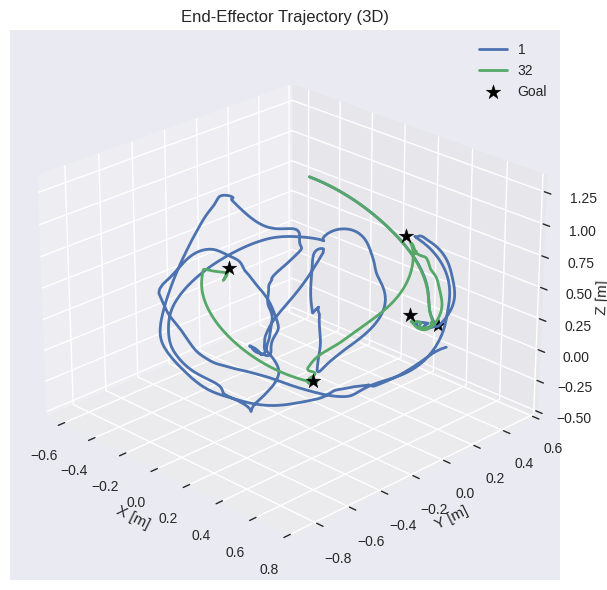

In [15]:
# 3D End-Effector Trajectory
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for res in results:
    stats = res['stats']
    ee_actual = np.asarray(stats['ee_actual'])  # (T, 3)
    ax.plot(ee_actual[:, 0], ee_actual[:, 1], ee_actual[:, 2], label=res['label'], linewidth=2)

# Plot goals
for i, goal in enumerate(goals):
    ax.scatter(goal[0], goal[1], goal[2], marker='*', s=120, c='k', label='Goal' if i == 0 else None)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('End-Effector Trajectory (3D)')
ax.legend(loc='best')
ax.view_init(elev=25, azim=-45)
plt.tight_layout()
plt.savefig(f'ee_traj3d.png', dpi=300)
plt.show()

In [ ]:
# Tracking Error
fig, ax = plt.subplots(figsize=(8, 4))
for res in results:
    stats = res['stats']
    t = np.asarray(stats['timestamps'])
    if 'goal_distances' in stats and len(stats['goal_distances']) == len(t):
        err = np.asarray(stats['goal_distances'])
    else:
        # Fallback: compute from ee_actual and ee_goal
        ee_actual = np.asarray(stats['ee_actual'])
        ee_goal = np.asarray(stats['ee_goal'])
        err = np.linalg.norm(ee_actual[:, :3] - ee_goal[:, :3], axis=1)
    ax.plot(t, err, label=res['label'], linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Tracking Error [m]')
ax.set_title('End-Effector Tracking Error vs Time')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()
plt.savefig(f'tracking_error.png', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
run_labels = []
reached_counts = []
timeout_counts = []
for res in results:
    stats = res['stats']
    outcomes = list(stats.get('goal_outcomes_by_idx', []))
    run_labels.append(res['label'])
    reached_counts.append(sum(1 for o in outcomes if o == 'reached'))
    timeout_counts.append(sum(1 for o in outcomes if o != 'reached'))

x = np.arange(len(run_labels))
width = 0.35
ax.bar(x - width/2, reached_counts, width, label='Reached', color='#2ca02c')
ax.bar(x + width/2, timeout_counts, width, label='Timeout/Not Reached', color='#d62728')
ax.set_xticks(x)
ax.set_xticklabels(run_labels, rotation=15)
ax.set_ylabel('Count')
ax.set_title('Goal Outcomes per Run')
ax.legend(loc='best')
plt.tight_layout()
plt.savefig(f'goal_outcomes.png', dpi=300)
plt.show()

In [ ]:
# Solve Time
fig, ax = plt.subplots(figsize=(8, 4))
for res in results:
    stats = res['stats']
    t = np.asarray(stats['timestamps'])
    solve_ms = np.asarray(stats['solve_times'])
    ax.plot(t, solve_ms, label=res['label'], linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Solve Time [ms]')
ax.set_title('Solve Time vs Time')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')
plt.tight_layout()
plt.savefig(f'solve_time.png', dpi=300)
plt.show()

In [ ]:
# Extract time and EE positions
t1 = np.asarray(mpc_stats_1['timestamps'])
ee1 = np.asarray(mpc_stats_1['ee_actual'])  # (T1, 3)

t64 = np.asarray(mpc_stats_32['timestamps'])
ee64 = np.asarray(mpc_stats_32['ee_actual'])  # (T64, 3)

fig, axs = plt.subplots(3, 1, figsize=(9, 7), sharex=True)

axs[0].plot(t1, ee1[:, 0], label='mpc_1', linewidth=2)
axs[0].plot(t64, ee64[:, 0], label='mpc_64', linewidth=2)
axs[0].set_ylabel('X [m]')
axs[0].grid(True, alpha=0.3)
axs[0].legend(loc='best')

axs[1].plot(t1, ee1[:, 1], label='mpc_1', linewidth=2)
axs[1].plot(t64, ee64[:, 1], label='mpc_64', linewidth=2)
axs[1].set_ylabel('Y [m]')
axs[1].grid(True, alpha=0.3)
axs[1].legend(loc='best')

axs[2].plot(t1, ee1[:, 2], label='mpc_1', linewidth=2)
axs[2].plot(t64, ee64[:, 2], label='mpc_64', linewidth=2)
axs[2].set_ylabel('Z [m]')
axs[2].set_xlabel('Time [s]')
axs[2].grid(True, alpha=0.3)
axs[2].legend(loc='best')

fig.suptitle('End-Effector Trajectory Components: mpc_1 vs mpc_64', y=0.98)
plt.tight_layout()
plt.show()


In [ ]:
def segments_from_stats(stats):
    ee_goal = np.asarray(stats['ee_goal'])  # (T, 3)
    T = ee_goal.shape[0]
    if T == 0:
        return []
    change_idxs = [0]
    for i in range(1, T):
        if not np.allclose(ee_goal[i], ee_goal[i - 1], atol=1e-9):
            change_idxs.append(i)
    change_idxs.append(T)
    segments = []
    for s, e in zip(change_idxs[:-1], change_idxs[1:]):
        segments.append({'start': s, 'end': e, 'goal': ee_goal[s]})
    return segments


seg1 = segments_from_stats(mpc_stats_1)
seg32 = segments_from_stats(mpc_stats_32)
seg128 = segments_from_stats(mpc_stats_128)

num_goals = max(len(seg1), len(seg32), len(seg128))

# Prepare data arrays
EE1 = np.asarray(mpc_stats_1['ee_actual'])  # (T1, 3)
EE32 = np.asarray(mpc_stats_32['ee_actual'])  # (T32, 3)
EE128 = np.asarray(mpc_stats_128['ee_actual'])  # (T128, 3)

# Plot each goal segment individually
for i in range(num_goals):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot mpc_1 segment
    if i < len(seg1):
        s, e = seg1[i]['start'], seg1[i]['end']
        traj = EE1[s:e]
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label='mpc_1', linewidth=2, color='red')
        goal_pt_1 = seg1[i]['goal']
    else:
        goal_pt_1 = None

    # Plot mpc_32 segment
    if i < len(seg32):
        s2, e2 = seg32[i]['start'], seg32[i]['end']
        traj2 = EE32[s2:e2]
        ax.plot(traj2[:, 0], traj2[:, 1], traj2[:, 2], label='mpc_32', linewidth=2, color='green')
        goal_pt_32 = seg32[i]['goal']
    else:
        goal_pt_32 = None

    # Plot mpc_128 segment
    if i < len(seg128):
        s3, e3 = seg128[i]['start'], seg128[i]['end']
        traj3 = EE128[s3:e3]
        ax.plot(traj3[:, 0], traj3[:, 1], traj3[:, 2], label='mpc_128', linewidth=2, color='blue')
        goal_pt_128 = seg128[i]['goal']
    else:
        goal_pt_128 = None

    goal_pt = goal_pt_1 if goal_pt_1 is not None else (goal_pt_32 if goal_pt_32 is not None else goal_pt_128)
    if goal_pt is not None:
        ax.scatter(goal_pt[0], goal_pt[1], goal_pt[2], marker='*', s=100, c='k', label='goal')
        ax.set_title(f'Goal {i}: [{goal_pt[0]:.2f}, {goal_pt[1]:.2f}, {goal_pt[2]:.2f}]')
    else:
        ax.set_title(f'Goal {i}')

    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.legend(loc='best', fontsize=8)
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Plot X, Y, Z components separately for each goal segment, overlaying mpc_1, mpc_32, and mpc_128

# Use the segments_from_stats function defined in the previous cell
seg1 = segments_from_stats(mpc_stats_1)
seg32 = segments_from_stats(mpc_stats_32)
seg128 = segments_from_stats(mpc_stats_128)
num_goals = max(len(seg1), len(seg32), len(seg128))

# Full arrays
T1 = np.asarray(mpc_stats_1['timestamps'])
EE1 = np.asarray(mpc_stats_1['ee_actual'])
T32 = np.asarray(mpc_stats_32['timestamps'])
EE32 = np.asarray(mpc_stats_32['ee_actual'])
T128 = np.asarray(mpc_stats_128['timestamps'])
EE128 = np.asarray(mpc_stats_128['ee_actual'])

for gi in range(num_goals):
    fig, axs = plt.subplots(3, 1, figsize=(9, 6), sharex=False)

    goal_pt = None

    # mpc_1 segment
    if gi < len(seg1):
        s, e = seg1[gi]['start'], seg1[gi]['end']
        t_rel = T1[s:e] - T1[s]
        axs[0].plot(t_rel, EE1[s:e, 0], label='mpc_1', linewidth=1, color='red')
        axs[1].plot(t_rel, EE1[s:e, 1], label='mpc_1', linewidth=1, color='red')
        axs[2].plot(t_rel, EE1[s:e, 2], label='mpc_1', linewidth=1, color='red')
        goal_pt = seg1[gi]['goal']

    # mpc_32 segment
    if gi < len(seg32):
        s2, e2 = seg32[gi]['start'], seg32[gi]['end']
        t_rel2 = T32[s2:e2] - T32[s2]
        axs[0].plot(t_rel2, EE32[s2:e2, 0], label='mpc_32', linewidth=1, color='green')
        axs[1].plot(t_rel2, EE32[s2:e2, 1], label='mpc_32', linewidth=1, color='green')
        axs[2].plot(t_rel2, EE32[s2:e2, 2], label='mpc_32', linewidth=1, color='green')
        if goal_pt is None:
            goal_pt = seg32[gi]['goal']

    # mpc_128 segment
    if gi < len(seg128):
        s3, e3 = seg128[gi]['start'], seg128[gi]['end']
        t_rel3 = T128[s3:e3] - T128[s3]
        axs[0].plot(t_rel3, EE128[s3:e3, 0], label='mpc_128', linewidth=1, color='blue')
        axs[1].plot(t_rel3, EE128[s3:e3, 1], label='mpc_128', linewidth=1, color='blue')
        axs[2].plot(t_rel3, EE128[s3:e3, 2], label='mpc_128', linewidth=1, color='blue')
        if goal_pt is None:
            goal_pt = seg128[gi]['goal']

    if goal_pt is not None:
        axs[0].axhline(goal_pt[0], linestyle='--', color='k', alpha=0.6, label='goal')
        axs[1].axhline(goal_pt[1], linestyle='--', color='k', alpha=0.6, label='goal')
        axs[2].axhline(goal_pt[2], linestyle='--', color='k', alpha=0.6, label='goal')

    axs[0].set_ylabel('X [m]')
    axs[1].set_ylabel('Y [m]')
    axs[2].set_ylabel('Z [m]')
    axs[2].set_xlabel('Elapsed Time [s]')

    for ax in axs:
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')

    if goal_pt is not None:
        fig.suptitle(f'Goal {gi} components: [{goal_pt[0]:.2f}, {goal_pt[1]:.2f}, {goal_pt[2]:.2f}]', y=0.98)
    else:
        fig.suptitle(f'Goal {gi} components', y=0.98)

    plt.tight_layout()
    plt.show()